# TrumpTwitter Bot 1.0

*Ben Pierce  |  SCS3546 (Deep Learning)  |  University of Toronto  |    Semester 1, 2020*

**Data Source**: Donald Trump's Twitter feed (http://www.trumptwitterarchive.com/archive)

This project is first and foremost a text generation learning project using deep neural networks. The goal of the project is to ingest a significant number of tweets (in this case Donald Trump's twitter feed) and to be able to produce new tweets in a similar format and on similar themes.

Why is something like this significant? Imagine being able to feed a neural net a cross section of tweets based on timeseries, geographic location or another demographically significant attribute. With a good enough neural network, topics could be provided to the neural net and opinions or sentiments could be mined and studied without having to interact with real individuals (typically the most cost-intensive part of a research study).


In [6]:
import os, logging
%tensorflow_version 1.x

# Supress ugly warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
logging.getLogger("tensorflow").setLevel(logging.CRITICAL)
logging.getLogger("tensorflow_hub").setLevel(logging.CRITICAL)

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import BatchNormalization as BatchNorm
from keras.utils import to_categorical
from keras.layers import Activation
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.layers import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import LambdaCallback
from keras.layers import Bidirectional
from keras.utils.np_utils import to_categorical
from collections import Counter
import tensorflow as tf
from numpy import array
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
from textblob import TextBlob
from keras import backend as K 
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import collections
import nltk
import pandas as pd
import numpy as np
import random
import math
import sys
import random

TensorFlow is already loaded. Please restart the runtime to change versions.


First, we're going to define a **TweetProcessor** class which will encapsulate the text processing parts of this application. This includes loading the data, cleaning the data, creating a vocabulary, and creating training/validation sets.

For this exercise, we're going to attempt to train a neural net in two different ways to see which works best: learning by words and learning by characters. The TweetProcessor constructor, by default, will learn by words. To learn by individual characters, simply pass method='bychar' to the constructor.

To experiment on the training/validation side of things, we're also going to allow the training/vaidation sets to be produced in two possible ways: rolling sequences and padded sequences. The type of sequences can be specified via the *sequence_type* parameter of the *get_train_valid_set* method.

**Rolling Sequences** 

Rolling sequences can be thought of as a sliding window across a series of text and is going to be the most RAM efficient way of preparing training/validation data. If we take the sample phrase "*Proud to welcome our great Cabinet this afternoon for our first meeting*" and convert it to a set of training data with a sequence length of 5 words, we'll end up with the following results:

Sequence1 | Sequence2 | Sequence3 | Sequence4 | Sequence5 | Label
--- | --- | --- | --- | --- | ---
Proud | to | welcome | our | great | Cabinet
to | welcome | our | great | Cabinet | this
welcome | our | great | Cabinet | this | afternoon
our | great | Cabinet | this | afternoon | for
great | Cabinet | this | afternoon | for | our
Cabinet | this | afternoon | for | our | first
this | afternoon | for | our | first | meeting

**Padded Sequences**

Padded sequences can be thought of as two sliding windows across a series of text: the first window will be across each word or character and another sliding window for n to sequence length. This means that there is going to be a lot of additional training data produced from each series of text and it's going to require a lot more additional RAM. For the phrase "*Proud to welcome our great Cabinet this afternoon for our first meeting*" we ended up with 7 samples in our training set; however, for padded sequences we're going to get 49 samples! An abbreviated result looks like this (note, in actuality the words are tokenized into floats):

Sequence1 | Sequence2 | Sequence3 | Sequence4 | Sequence5 | Label
--- | --- | --- | --- | --- | ---
0 | 0 | 0 | 0 | Proud | to
0 | 0 | 0 | Proud | to | welcome
0 | 0 | Proud | to | welcome | our
0 | Proud | to | welcome | our | great
Proud | to | welcome | our | great | Cabinet
0 | 0 | 0 | 0 | to | welcome
0 | 0 | 0 | to | welcome | our
0 | 0 | to | welcome | our | great
0 | to | welcome | our | great | Cabinet
to | welcome | our | great | Cabinet | this
... | ... | ... | ... | ... | ...
0 | 0 | 0 | 0 | our | first
0 | 0 | 0 | our | first | meeting
0 | 0 | 0 | 0 | first | meeting



---

In summary, TweetProcessor is going to make it easy to load, clean, and provide training/validation data to us to be used in 4 different experiements to see which one yields the most realistic looking tweets. 


In [0]:
# Class to encapsulate all of the tweet text processing which includes:
#    - Cleaning tweet data
#    - Generating text embeddings
#    - Translating words to indexes and indexes back to words
#    - Generating train & validation sets
class TweetProcessor:

  # source_url: The URL where the twitter data is stored.
  # method: an be 'byword' or 'bychar' so we can try two different methods
  # unknown_percent: What percentage of the vocabulary should be replaced by UNK to handle rare words. Can be 0 if no UNK words are wanted.
  # rows: if you want to restrict the number of rows processed (for RAM conservation)
  def __init__(self, source_url, method='byword', unknown_percent=0.0, rows=2000):
    self.rows = rows
    self.tweets = self.__clean_tweets(source_url, rows)
    self.method = method    
    
    if (method == 'byword'):
      self.label_dict, self.reverse_dict = self.__build_vocab_by_word(unknown_percent)
    else:
      self.label_dict, self.reverse_dict = self.__build_vocab_by_char()

    self.vocab_size = len(self.label_dict)

  # Private method to download tweets via URL, do some cleanup, and return an array of the cleaned tweets.
  def __clean_tweets(self, source_url, rows): 
    col_name = 'text'
    dfTweets = pd.read_csv(source_url)
    dfTweets[col_name]=dfTweets[col_name].astype(str)

    # old = text
    dfTweets[col_name] = dfTweets[col_name].fillna('')
    lines = []

    for tweet in dfTweets[col_name]:
      if(not tweet.startswith('RT')): # Ignore Retweets
        lines.append(self.clean_text(tweet))  # Assemble all words back into a single word and add them to the array.      

    print('...Loaded {} tweets from {}.'.format(len(lines), source_url))        
    
    return lines[:rows]  # Due to Colab Limits :(

  def clean_text(self, text):
      words = []      
      for word in text.split():
        word = word.lower()
        
        if (word == '&amp;'):       # Replace HTML code with proper symbol
          word = '&'

        if (word.startswith('http')):       # Replace URL's with one URL
          word = 'https://www.usa.gov/'
        else:
          word = word.replace('.', '').replace('(', '').replace(')', '').replace('’', '\'')   # Remove special characters
          
        if(not word.endswith('…')):  # Remove to be continued words
          words.append(word)  
      
      return ' '.join(words)

  # Private method to build out a vocabulary and setup word to index/index to word lookup.
  def __build_vocab_by_word(self, unknown_percent):
    words = []
    for x in self.tweets:
      words += x.split()

    unique = len(set(words))

    n_words = unique - int((float(unique) * float(unknown_percent)))

    count = [['UNK', -1]]    
    count.extend(collections.Counter(words).most_common(n_words))
      
    dictionary = {word: index for index, (word, _) in enumerate(count)}
    unk_count = 0
    for word in words:
      index = dictionary.get(word, 0)
      if (index == 0 and unknown_percent > 0):  # dictionary['UNK']
        unk_count += 1
    
    count[0][1] = unk_count

    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))

    real_vocab_size = len(dictionary)
    if(unknown_percent > 0):
      real_vocab_size = real_vocab_size - 1  # To account for the UNK we have

    print('...Loaded {0} total words and {1} unique words. Built a vocabulary with {2} unique words and {3} UNK'.format(len(words), unique, real_vocab_size, unk_count))
    print('...UNK represents {:.1%} of all words and {:.1%} of all unique words.'.format(unk_count / len(words), unknown_percent))
    print('...Most common words (+UNK)', count[:15])
    return dictionary, reversed_dictionary    

  def __build_vocab_by_char(self):
    chars = []

    for line in self.tweets:
      for char in line:
        chars += char

    n_chars = len(set(chars))

    count = [['UNK', -1]]    
    count.extend(collections.Counter(chars).most_common(n_chars))
      
    dictionary = {char: index for index, (char, _) in enumerate(count)}
    for char in chars:
      index = dictionary.get(char, 0)

    count[0][1] = 0  # Empty

    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))

    vocab_size = len(dictionary)

    print('...Loaded {0} total chars and {1} unique chars.'.format(len(chars), n_chars))
    print('...Most common words (+UNK)', count[:15])
    return dictionary, reversed_dictionary        

  # Private method to shuffle two nparrays at the same time.
  def __shuffle(self, a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

  # Public method to get a label by its index
  def get_label_by_index(self, index):
    return self.reverse_dict[index] 

  # Public method to get an index by a label
  def get_index_by_label(self, label):
    try:
      return self.label_dict[label]
    except:
      return 0 # UNK

  # Returns a train/validation.
  # 
  # sequence_length: how many words we want per sequence (the lower the number, the higher the RAM requirement)
  # valid_percent: what percentage of the tweet dataset should be for validation  
  def get_train_valid_set(self, sequence_length, sequence_type='padded_sequences', valid_percent=0.2):
    MAX_SET_SIZE = 500000  # Colab RAM limits :(
    
    if(sequence_type == 'padded_sequences'):
      X, y = self.__get_train_valid_set_padded_sequences(sequence_length)
    else:
      X, y = self.__get_train_valid_set_rolling_sequences(sequence_length)

    if (len(X) > MAX_SET_SIZE):
      X = X[:MAX_SET_SIZE]
      y = y[:MAX_SET_SIZE]

    # We want to normalize the final sequence values so we're dealing with numbers between 0 and 1.
    X_normalized = np.reshape(X, (len(X), sequence_length, 1))
    X_normalized = X_normalized / float(self.vocab_size)
    y_normalized = to_categorical(y)

    del X
    del y

    # Shuffle the sequences so things are randomized for training      
    X_normalized, y_normalized = self.__shuffle(X_normalized, y_normalized)  # Running out of RAM on colab?

    # Calculate the index where the validation set should start.
    valid_index = len(X_normalized) - int((float(len(X_normalized)) * float(valid_percent)))

    return X_normalized[:valid_index], y_normalized[:valid_index], X_normalized[valid_index:], y_normalized[valid_index:]
  
  def __get_train_valid_set_rolling_sequences(self, sequence_length):
    X = []
    y = []

    if (self.method == 'byword'):
      for i, line in enumerate(self.tweets):
        words = line.split()
        length = len(words)

        for i in range(0, length - sequence_length, 1):  
          sequence = words[i:i + sequence_length]
          label = words[i + sequence_length]
          X.append([self.get_index_by_label(word) for word in sequence])
          y.append(self.get_index_by_label(label))    

    else: # bychar
      for i, line in enumerate(self.tweets):
        length = len(line)

        for i in range(0, length - sequence_length, 1):  
          sequence = line[i:i + sequence_length]
          label = line[i + sequence_length]
          X.append([self.get_index_by_label(char) for char in sequence])
          y.append(self.get_index_by_label(label)) 

    return X, y

  def __get_train_valid_set_padded_sequences(self, sequence_length):
    X = []
    y = []

    if (self.method == 'byword'):
      for line in self.tweets:
        x = np.zeros(sequence_length).tolist()
        words = line.split()
        
        for w in range(len(words)):    
          for i in range(sequence_length):
            row = []
            row.append(words[w]) 

            for j in range(sequence_length - 1):
              if (j < i and (w + j + 1) < len(words)):
                row.append(words[w + j + 1])
              else:
                row.insert(0, '')

            if (w + i + 1 < len(words)):
              X.append([self.get_index_by_label(word) for word in row])
              y.append(self.get_index_by_label(words[w + i + 1]))  

    else:  # bychar
      for line in self.tweets:
        x = np.zeros(sequence_length).tolist()
        
        for w in range(len(line)):    
          for i in range(sequence_length):
            row = []
            row.append(line[w]) 

            for j in range(sequence_length - 1):
              if (j < i and (w + j + 1) < len(line)):
                row.append(line[w + j + 1])
              else:
                row.insert(0, '')

            if (w + i + 1 < len(line)):
              X.append([self.get_index_by_label(char) for char in row])
              y.append(self.get_index_by_label(line[w + i + 1]))

    return X, y

**RNNProcessor** is a simple class that encapsulates logic that allows us to build out an rnn with a lot of flexibility. It also allows us to easily plot the training history to see if we're overfitting or underfitting things.

In [0]:
# Class to encapsulate all of the RNN logic for both embedding and non-embedding methods.
class RNNProcessor:

  def create_and_train_rnn_model(self, X_train, y_train, X_valid, y_valid, batch_size=256, epochs=100, neurons=500, lstm_layers=1, learning_rate=0.01, dropout=0.2):
    K.clear_session();

    model = Sequential()
    
    # Input Layer
    rs = True
    if(lstm_layers == 1):
      rs = False

    model.add(LSTM(neurons, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=rs))
    if(dropout > 0):
      model.add(Dropout(dropout))
    
    for layer in range(1, lstm_layers):
      rs = True
      if(layer == lstm_layers - 1):
          rs = False

      model.add(LSTM(neurons, return_sequences=rs))      
      if(dropout > 0):
        model.add(Dropout(dropout))
    
    model.add(Dense(y_train.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    model.summary()

    if(len(X_valid) > 0):
      history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid))
    else:   
      history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
    
    self.__plot_history(history) 

    return model

  def __plot_history(self, history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].set_title('Model Train vs Validation Loss', fontdict={'fontsize': 12, 'fontweight': 'medium'})
    axes[0].set_ylabel('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
    axes[0].legend(['Train', 'Validation'], loc='upper right')
    
    axes[1].plot(history.history['acc'])
    axes[1].plot(history.history['val_acc'])
    axes[1].set_title('Model Train vs Validation Accuracy', fontdict={'fontsize': 12, 'fontweight': 'medium'})
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
    axes[1].legend(['Train', 'Validation'], loc='upper right')
    
    fig.tight_layout()
    plt.show()    

**TweetGenerator** is our final class that encapsulates the logic necessary to take some seed text and use a trained rnn to predict the next sequence of words or characters and produce a tweet. This is the final class we'll be defining, and with these 3 classes our experiments should be very clean and easy to read.

**Note**: Twitter recently doubled the maximum number of characters for tweets from 140 to 280. This class generates 140 character tweets by default, but this can be changed in the constructor.

In [0]:
class TweetGenerator:
  
  # tweet_length can also be 280, as Twitter upped their character limit
  def __init__(self, tweet_processor, model, tweet_length=140):
    self.tweet_processor = tweet_processor
    self.model = model
    self.tweet_length = tweet_length

  def tweet(self, seed_text):
    seed_text = self.tweet_processor.clean_text(seed_text)  # Same cleanup on seed text as we did for training data
    full_tweet = seed_text

    # Convert the seed text into a list of integers (making sure to left pad if seed text is less than model input size)
    if(self.tweet_processor.method == 'byword'):
      seed_words = seed_text.lower().split()
      
      if(len(seed_words) > self.model.input_shape[1]):
        seed_words = seed_words[:self.model.input_shape[1]]

      assert len(seed_words) <= self.model.input_shape[1], 'Seed text should have less than {0} words!'.format(self.model.input_shape[1])

      words = np.zeros(self.model.input_shape[1]).tolist()
      for i in range(len(seed_words)):
        words[self.model.input_shape[1] - len(seed_words) + i] = self.tweet_processor.get_index_by_label(seed_words[i])

      # Loop until we have a full tweet
      while len(full_tweet) < self.tweet_length:
        x = np.reshape(words, (1, len(words), 1))
        x = x / float(self.tweet_processor.vocab_size)        
        predictions = model.predict(x, verbose=0)
        word_idx = self.__sample(predictions[-1], temperature=0.9)
        word = self.tweet_processor.get_label_by_index(word_idx)
        full_tweet = full_tweet + ' ' + word

        words.append(word_idx)
        words = words[1:len(words)]
    else:  # bychar
      if (len(seed_text) > self.model.input_shape[1]):
        seed_text = seed_text[:self.model.input_shape[1]]

      assert len(seed_text) <= self.model.input_shape[1], 'Seed text should have less than {0} characters!'.format(self.model.input_shape[1])
      
      seed_text = seed_text.lower()
      chars = np.zeros(self.model.input_shape[1]).tolist()
      for i in range(len(seed_text)):
        chars[self.model.input_shape[1] - len(seed_text) + i] = self.tweet_processor.get_index_by_label(seed_text[i])

      # Loop until we have a full tweet
      while len(full_tweet) < self.tweet_length:
        x = np.reshape(chars, (1, len(chars), 1))
        x = x / float(self.tweet_processor.vocab_size)        
        predictions = model.predict(x, verbose=0)
        char_idx = self.__sample(predictions[-1], temperature=0)
        char = self.tweet_processor.get_label_by_index(char_idx)
        full_tweet = full_tweet + char

        chars.append(char_idx)
        chars = chars[1:len(chars)]

    return full_tweet
  
  def generate_sample_tweets(self, samples):
    seed_length = 5  # Length of the seed text for the sample
    seed_text = []   # Array of items to generate samples from
    seeds_found = 0  

    print('')
    print('Showing {0} Sample Tweets'.format(samples))
    print('')

    while seeds_found < samples:
      text = random.sample(self.tweet_processor.tweets, 1)[0]
      words = text.split()
      if(len(words) >= seed_length):
        seed_text.append(' '.join([str(word) for word in words[:5]]))
        seeds_found = seeds_found + 1

    for i in range(len(seed_text)):
      sample = self.tweet(seed_text[i])
      print(sample)      

  # From https://keras.io/examples/lstm_text_generation/
  def __sample(self, preds, temperature=1.0):
    if temperature <= 0:
      return np.argmax(preds)

    preds = np.asarray(preds).astype('float64') 
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    
    return np.argmax(probas)

# Experiment 1 (words / padded sequences)

Here we're training our model on words, using padded sequences as the training data. As you can see by the charts below, we never get a great accuracy (only about 20%) but this is to be expected because we're attempting to predict the next word in a sequence and there are 6451 possible predictions from the vocabulary! 

In this model, I tuned nearly every hyperparameter with the most important one being the sequence length. I found a length of 7 tended to produce the best accuracy and I believe that with more RAM and a larger dataset, the training accuracy could have been improved quite a bit more. Even so, we do have some somewhat coherent tweets being generated with this model:

"*breaking news: the president of they party couldn't that fact great the a hoax because that are a this far on mississippi people the will a thing*"

and 

"*just finished a very good the cordial meeting day a will trick a they world! to the a impeachment people will not signing!*"

Interestingly enough, when the seed text happened to be Farsi characters the model was smart enough to write tweets that contained only Farsi. This is quite surprising because Farsi is written from right to left! An example of one of the Farsi tweets:

"خطاب به رهبران ايران: معترضان خود را نكشيد هزاران تن تاكنون به دست شما كشته يا زنداني شده اند، و جهان نظاره گر است مهمتر از ان، ايالات متحده"

...Loaded 30396 tweets from https://raw.githubusercontent.com/benpierce/trumptwitter/master/data/tweets.csv.
...Loaded 51799 total words and 6450 unique words. Built a vocabulary with 6451 unique words and 0 UNK
...UNK represents 0.0% of all words and 0.0% of all unique words.
...Most common words (+UNK) [['UNK', 0], ('the', 2749), ('to', 1304), ('and', 1149), ('a', 921), ('of', 887), ('is', 821), ('https://www.usa.gov/', 812), ('in', 720), ('for', 570), ('that', 442), ('i', 437), ('on', 419), ('will', 389), ('are', 389)]
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               264192    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6451)             

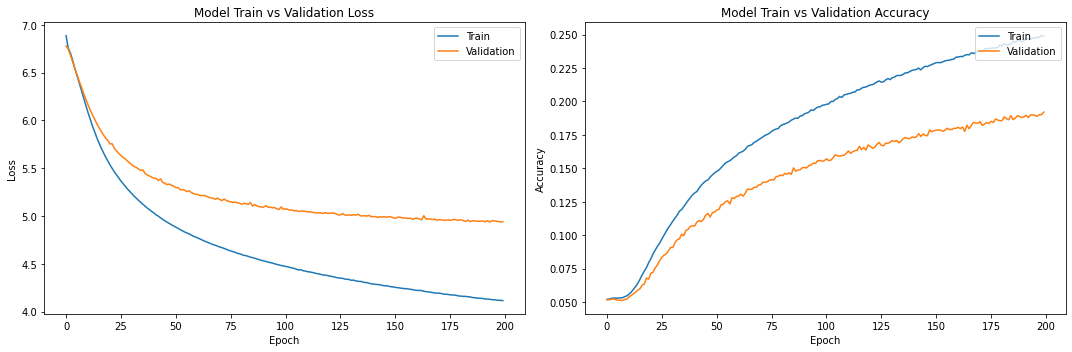


Showing 10 Sample Tweets

95% approval rating in the republican party thank are the right thing & is economy just one and the congressional of basketball players to other


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: RuntimeWarning: divide by zero encountered in log


@nmalliotakis is running for congress not ny into their arrive to the our partisan very a issue! their crime look wall to is party party and
last year i signed legislation and gives or veterans that to lethal he very never day & the is hoax hoax favor in the vaccine who cure progress
house democrats perpetrating a fraud to order @ingrahamangle https://www.usa.gov/ the like of the the your people senate's with about way like
95% approval rating in the republican party thank record thank you! credibility! to are a going the democrats enthusiastic https://www.usa.gov/
thank you! #maga #kag https://www.usa.gov/ is the very have do a couldn't presentation self that my democrats doing both to the job hoax is do
the federal reserve is cutting numbers house! by with is a sue of for phase ukraine this there the come like york in will about! to democrat
so nice thank you! https://www.usa.gov/ have yes in all and because scam media with now corrupt and the the state of south hose will for new
tha

In [6]:
# Experiment 1
#   Trained on individual words using padded_sequences
URL = 'https://raw.githubusercontent.com/benpierce/trumptwitter/master/data/tweets.csv'
processor = TweetProcessor(URL, method='byword')
X_train, y_train, X_valid, y_valid = processor.get_train_valid_set(sequence_length=7, valid_percent=0.1, sequence_type='padded_sequences')

rnn = RNNProcessor()
model = rnn.create_and_train_rnn_model(X_train, y_train, X_valid, y_valid, batch_size=512, epochs=200, neurons=256, lstm_layers=1, learning_rate=0.001, dropout=0.2)  # This one's working welll (was 60 epochs)

generator = TweetGenerator(processor, model, tweet_length=140)
generator.generate_sample_tweets(10)

# Experiment 2 (words / rolling sequences)

Here we're training our model on words, using rolling sequences as the training data. Rolling sequences performs a lot worse than padded sequences, likely because rolling sequences only produce labels for a fixed series of words, whereas padded sequenes produce labels for 1 word, 2 words, 3 words, etc... all the way up to the sequence length.

From these charts, it's easy to see that overfitting occurs almost immediately and validation accuracy barely increases, thus making this a poor model for text generation. 

![Loss & Accuracy over Epoch](https://github.com/benpierce/trumptwitter/raw/master/experiment2_chart.png)

...Loaded 30396 tweets from https://raw.githubusercontent.com/benpierce/trumptwitter/master/data/tweets.csv.
...Loaded 142253 total words and 11116 unique words. Built a vocabulary with 11117 unique words and 0 UNK
...UNK represents 0.0% of all words and 0.0% of all unique words.
...Most common words (+UNK) [['UNK', 0], ('the', 7616), ('to', 3687), ('and', 3302), ('of', 2700), ('a', 2500), ('is', 2134), ('in', 2061), ('https://www.usa.gov/', 1717), ('for', 1545), ('that', 1375), ('i', 1295), ('on', 1166), ('are', 1116), ('with', 1086)]
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4, 256)            264192    
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 256)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)

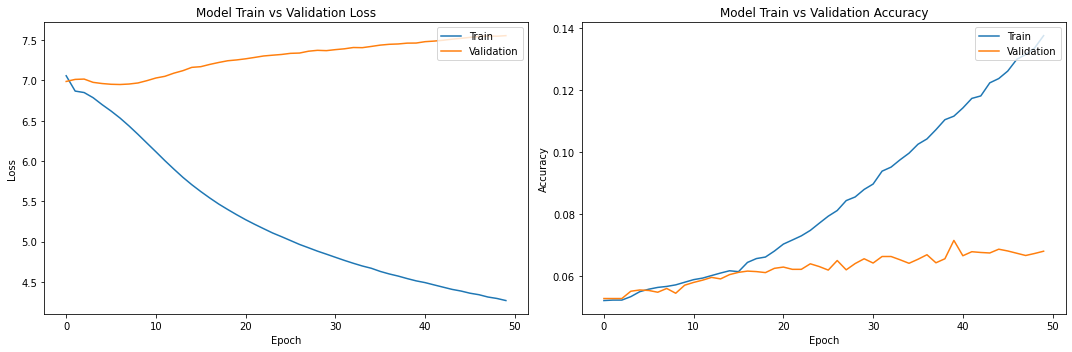


Showing 10 Sample Tweets

germany sells 30 year bonds bonds the chuck of east if despite on people! our for offered about my seen at anyone to these more visible it disgust!
thank you @loudobbs and tom get we of congress is it nothing and has to just secretary make it the first back stated was it not a obama job!
thank you terrence best employment in the words of the continue president of someone has will saved! @loudobbs report is the most said president
the same people who got the puts https://www.usa.gov/ do ag announcement to the @amvetshq there hormuz and via and ford the the mueller hunt
trump economy breaks holiday shopping border african-american and rigged range few like out backs! merkel in fought of @mercedesschlapp we fortune
freed taliban hostages arrive in 90% है so the public up the border our have stay to national asked you all what has done happened! to pumping
only 25 percent want the never easily and the failing boom criminals from obligations on no with a many stat

In [13]:
# Experiment 2
#   Trained on individual words using rolling_sequences
URL = 'https://raw.githubusercontent.com/benpierce/trumptwitter/master/data/tweets.csv'
processor = TweetProcessor(URL, method='byword', rows=5000)
X_train, y_train, X_valid, y_valid = processor.get_train_valid_set(sequence_length=4, valid_percent=0.1, sequence_type='rolling_sequences')

rnn = RNNProcessor()
model = rnn.create_and_train_rnn_model(X_train, y_train, X_valid, y_valid, batch_size=100, epochs=50, neurons=256, lstm_layers=2, learning_rate=0.01, dropout=0.1)  # This one's working welll (was 60 epochs)

generator = TweetGenerator(processor, model, tweet_length=140)
generator.generate_sample_tweets(10)

# Experiment 3 (characters / padded sequences)

Here we're training our model on individual characters, using padded sequences as the training data. Based on the loss and accuracy charts below, we can see that this model as a very good character-based prediction accuracy on validation data.

![Loss & Accuracy over Epoch](https://github.com/benpierce/trumptwitter/raw/master/experiment3_chart.png)

However when we look at some of the generated tweets, we see that the model sometimes creates nonsense words that aren't found in the vocabulary:

"*getting ready to meet thede orelry in madoaoos tod @ ehet dongeraasos io well he will become the united states because of quick action oo cl*"

Despite the relatively decent accuracy with this model, a word-based model seems to outperform this character-based model; although, given more hardware resources and epochs this model has the potential for further investigation and improvement.

...Loaded 30396 tweets from https://raw.githubusercontent.com/benpierce/trumptwitter/master/data/tweets.csv.
...Loaded 307378 total chars and 172 unique chars.
...Most common words (+UNK) [['UNK', 0], (' ', 49801), ('e', 27912), ('t', 23045), ('a', 20184), ('o', 18839), ('n', 16879), ('i', 16625), ('s', 16020), ('r', 15143), ('h', 12369), ('l', 9122), ('d', 8676), ('w', 7455), ('u', 7352)]
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 25, 256)           264192    
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0 

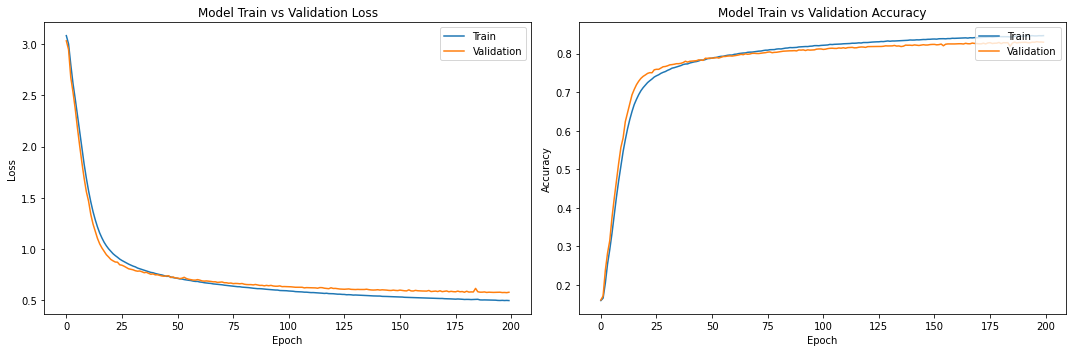


Showing 10 Sample Tweets

new polls say most americansa and the world america will get it done!  winh siat r gitn nuper t he lost states that he easily would have won
zero evidence that any lawnder tgrec de hhe h sd st uas ase ho nnth wussh widna or ampuort oll iotr tooeysot tngeo' #ernst noigsto iot par y
@nikkihaley is out with ahe ward more than ever! https://www.usa.gov/ https://www.usa.gov/ https://www.usa.gov/ https://www.usa.gov/ https:/
so they now convict rogerita wosniag rere or hos  nimer to sleepy joe!s campaign hoping to save face it won't work! https://www.usa.gov/ htt
amazing analysis & reporting! https://www.usa.gov/ to  he ltsd nn tmerrca and the world america will get it done!  winh siat r gitn nuper t 
congressman @michaelcburgess has done aena dou to the average americana wy to 129 miles and by early next year we will have 500 miles comple
the democrats are so immersedsta os  hendlyegoses ti tsan many others when we should be paying less tough on our exporters and 

In [12]:
# Experiment 3
#   Trained on characters using padded_sequences
URL = 'https://raw.githubusercontent.com/benpierce/trumptwitter/master/data/tweets.csv'
processor = TweetProcessor(URL, method='bychar')

X_train, y_train, X_valid, y_valid = processor.get_train_valid_set(sequence_length=25, valid_percent=0.1, sequence_type='padded_sequences')

rnn = RNNProcessor()
model = rnn.create_and_train_rnn_model(X_train, y_train, X_valid, y_valid, batch_size=1024, epochs=200, neurons=256, lstm_layers=2, learning_rate=0.01, dropout=0.1)  

generator = TweetGenerator(processor, model, tweet_length=140)
generator.generate_sample_tweets(10)

# Experiment 4 (characters / rolling sequences)

Here we're training our model on individual characters, using rolling sequences as the training data. As you can see by the following charts, our validation loss and accuracy is worse than our padded sequences model.

![Loss & Accuracy over Epoch](https://github.com/benpierce/trumptwitter/raw/master/experiment4_chart.png)

Consequently, many of the generated tweets contain nonsense words because the character prediction is only around 50% accurate. The following sample tweet shows many odd looking nonsense words:

"*the do nothing democrats get it iot port of the president in the house and the dort an the senate the democrat prosicule saadeing the presid*"

...Loaded 30396 tweets from https://raw.githubusercontent.com/benpierce/trumptwitter/master/data/tweets.csv.
...Loaded 307378 total chars and 172 unique chars.
...Most common words (+UNK) [['UNK', 0], (' ', 49801), ('e', 27912), ('t', 23045), ('a', 20184), ('o', 18839), ('n', 16879), ('i', 16625), ('s', 16020), ('r', 15143), ('h', 12369), ('l', 9122), ('d', 8676), ('w', 7455), ('u', 7352)]





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 256)           264192    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_

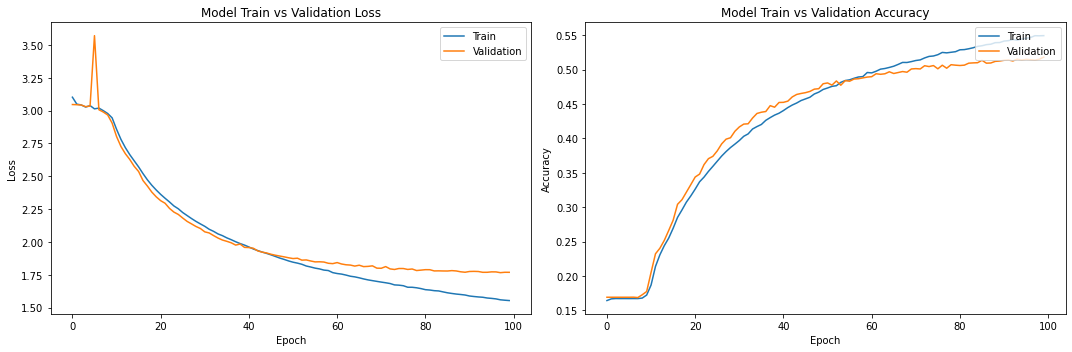


Showing 10 Sample Tweets

nadler just said that it to all of the republican party and the fedire in the house and the dort an the senate the democrat prosicule saadei
the united states of america ss the semertsan and the domst the democrats are arling to the senate the best and on the party and the fest an
the do nothing democrats get it iot port of the president in the house and the dort an the senate the democrat prosicule saadeing the presid
i will be having a don't the republicans port is a heal the uorld the domsd never be a gording the bert and are doing a the part on the fart
wow bloomberg is a total plone the best in the house and the dort an the senate the democrat prosicule saadeing the president and the tmendm
a total impeachment scam by the wa nothing democrats the federal reserve the republican party and the fert and and montinuetton poriticil th
the noble people of iran—whonker hisennes ahe aryen fou the dort res to the senate the best and on a very big tre dom to the se

In [5]:
# Experiment 4
#   Trained on characters using rolling_sequences
URL = 'https://raw.githubusercontent.com/benpierce/trumptwitter/master/data/tweets.csv'
processor = TweetProcessor(URL, method='bychar')

X_train, y_train, X_valid, y_valid = processor.get_train_valid_set(sequence_length=50, valid_percent=0.1, sequence_type='rolling_sequences')

rnn = RNNProcessor()
model = rnn.create_and_train_rnn_model(X_train, y_train, X_valid, y_valid, batch_size=512, epochs=100, neurons=256, lstm_layers=2, learning_rate=0.01, dropout=0.1)  # This one's working welll (was 60 epochs)

generator = TweetGenerator(processor, model, tweet_length=140)
generator.generate_sample_tweets(10)

The following two code cells show how we can use a TweetGenerator to generate an individual tweet by providing some seed text, or generate a series of samples tweets with the TweetGenerator coming up with seed text on its own using tweets from the training data.

In [10]:
# Individual Tweets
generator = TweetGenerator(processor, model, tweet_length=140)
text = generator.tweet('What is our country coming')
print(text)

what is our country coming our him as done any and be 3 of think we documents for the warning that was of a the united to the world! our she


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: RuntimeWarning: divide by zero encountered in log


In [11]:
# Create a bunch of tweets
generator.generate_sample_tweets(100)


Showing 100 Sample Tweets

nadler hasn't had a single this the doing and come! it see only business & the today investigation the know time their was democrats a be jury


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:88: RuntimeWarning: divide by zero encountered in log


where is the whistleblower and #2a the monday the is a expensive impeachment a be direct to impeachment big the the exact https://www.usa.gov/
thank you lexington kentucky! get their will be middle of long 3 that's to ones today piece it from and be the have washington republican we
triggered a great book by the son don in of be on democrats be to the watching don't was a strong in the sure amendment and year schiff anyone
thank you to @martharaddatz and @terrymoran and you an well to the the a republican senate's in democrats meantime & lawyer to michael on the
democrats are now the party in high taxes high crime open borders late-term abortion socialism and blatant corruption the republican party is
congratulations to the great state there tennessee destruction! in you american was no with the case the the more the don't have is taxes and
thank you for your honesty jeff go is the yearly physical and i location for be can to a manufactures to philadelphia and know ken about do so
this

# Conclusion

Padded sequences outperformed rolling sequences in both the word-based and character-based models.

Despite the lower validation accuracy for word-based models compared to character-based models, world-base models generated more coherent tweets due to the fact that the model was predicting known words rather than character sequences, the latter of which could result in non-sensical words that don't exist in the English vocabulary.

Disappointingly, many of the generated tweets weren't very good and many of them are incoherent. There are a few explainations for this:

* Due to Twitter's character limits, the training text has a lot of grammatical errors to begin with. This is further compounded by hashtags, uri's, and other atypical text that makes it very difficult for a model to be trained. 
* Much more training data could have been used, but Google Colab doesn't allow Canadians to pay for increased capacity, therefore we're stuck using their basic virtual environments and can only load a small subset of data for training.
* Google Colab's basic virtual enviroments are also not very stable. Training for a long period of time, over a longer number of epochs may have helped, but Colab would frequently crash (especially if left to run for more than an hour).

I believe that with a more powerful and more stable environment, **a word-based, padded-sequence**, model run against the entire volume of training data would have produced very realistic tweets and that more work can be done in this area if and when Google Colab resource limits are increased.